# Implementation of Softmax Regression from Scratch

In [1]:
!pip install torch torchvision

In [3]:
!pip install -U d2l

**We will work with the Fashion-MNIST dataset**, just introduced in Section 3.5, s**etting up a data iterator with batch size 256**.

In [5]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Initializing Model Parameters

As in our linear regression example, each example here will be represented by a fixed-length vector. Each example in the raw dataset is a **28 x 28** image. In this section, we will flatten each image, treating them as vectors of length 784. In the future, we will talk about more sophisticated strategies for exploiting the spatial structure in images, but for now we treat each pixel location as just another feature.

Recall that in softmax regression, we have as many outputs as there are classes. Because our dataset has 10 classes, our network will have an output dimension of 10. Consequently, our weights will constitute a **784 x 10** matrix and the biases will constitute a **1 x 10**  row vector. As with linear regression, we will initialize our weights W with Gaussian noise and our biases to take the initial value 0.

In [6]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

## Defining the Softmax Operation

Before implementing the softmax regression model, let us briefly review how the sum operator works along specific dimensions in a tensor, as discussed in Section 2.3.6 and Section 2.3.6.1. G**iven a matrix X we can sum over all elements (by default) or only over elements in the same axis**, i.e., the same *column (axis 0)* or the same *row (axis 1)*. **Note** that if **X** is a tensor with **shape (2, 3)** and we **sum over the columns, the result will be a vector with shape (3,)**. When invoking the sum operator, we can specify to keep the number of axes in the original tensor, rather than collapsing out the dimension that we summed over. This will result in a two-dimensional tensor with shape (1, 3).

In [7]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]), tensor([[ 6.],
         [15.]]))

**The denominator, or normalization constant**, is also sometimes called **the partition function** (and its logarithm is called the log-partition function). The origins of that name are in statistical physics where a related equation models the distribution over an ensemble of particles.

In [8]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

As you can see, for any random input, we turn each element into a non-negative number. Moreover, each row sums up to 1, as is required for a probability.

In [9]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0192, 0.1995, 0.1248, 0.4674, 0.1891],
         [0.4330, 0.1506, 0.2211, 0.0725, 0.1229]]), tensor([1.0000, 1.0000]))

## Defining the Model

Now that we have defined the softmax operation, we can implement the softmax regression model. The below code defines how the input is mapped to the output through the network. Note that we flatten each original image in the batch into a vector using the reshape function before passing the data through our model.

In [10]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

## Defining the Loss Function

Next, we need to **implement the cross-entropy loss function**, as introduced in Section 3.4. This may be the most common loss function in all of deep learning because, at the moment, classification problems far outnumber regression problems.

**Recall that cross-entropy takes the negative log-likelihood of the predicted probability assigned to the true label**. Rather than iterating over the predictions with a Python for-loop (which tends to be inefficient), we can **pick all elements by a single operator**. Below, we **create** sample data **y_hat** with 2 examples of predicted probabilities over 3 classes and their corresponding labels y. With y we know that in the first example the first class is the correct prediction and in the second example the third class is the ground-truth. **Using y as the indices of the probabilities in y_hat**, we pick the probability of the first class in the first example and the probability of the third class in the second example.

In [11]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [12]:
# implement the cross-entropy loss function efficiently with just one line of code

def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

## Classification Accuracy

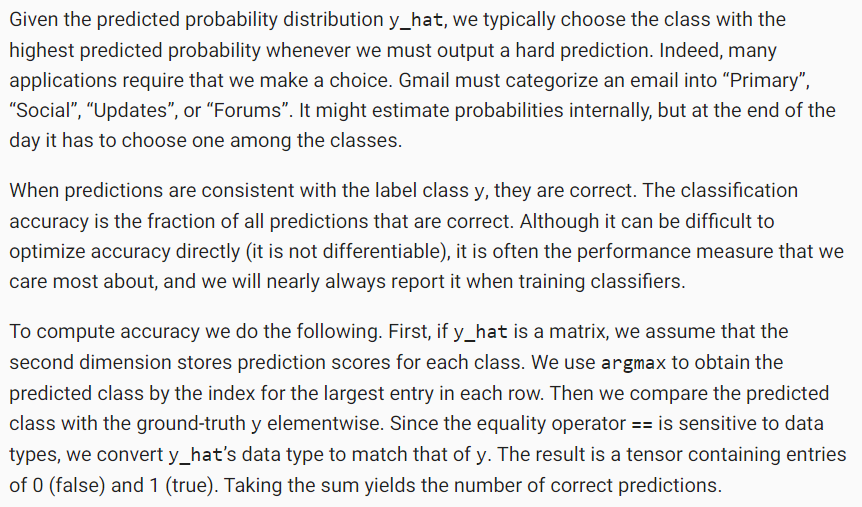

In [13]:
def accuracy(y_hat, y):  #save
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

We will continue to use the variables **y_hat** and y defined before as the predicted probability distributions and labels, respectively. We can see that the first example’s prediction class is 2 (the largest element of the row is 0.6 with the index 2), which is inconsistent with the actual label, 0. The second example’s prediction class is 2 (the largest element of the row is 0.5 with the index of 2), which is consistent with the actual label, 2. Therefore, the classification accuracy rate for these two examples is 0.5.

In [14]:
accuracy(y_hat, y) / len(y)

0.5

Similarly, we can evaluate the accuracy for any model net on a dataset that is accessed via the data iterator **data_iter**.

In [15]:
def evaluate_accuracy(net, data_iter):  #save
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions

    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

Here **Accumulator** is a **utility class to accumulate sums over multiple variables**. In the above **evaluate_accuracy** function, we **create 2 variables in the Accumulator** instance** for storing both the number of correct predictions and the number of predictions**, respectively. Both will be accumulated over time as we iterate over the dataset.

In [17]:
class Accumulator:  #save
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

Because we initialized the **net** model with random weights, the accuracy of this model should be close to random guessing, i.e., 0.1 for 10 classes.

In [18]:
evaluate_accuracy(net, test_iter)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.063

## Training

In [19]:
def train_epoch_ch3(net, train_iter, loss, updater):  #save
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # Using PyTorch in-built optimizer & loss criterion
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # Using custom built optimizer & loss criterion
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

Before showing the implementation of the training function, we define a utility class that plot data in animation

In [20]:
class Animator:  #save
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

The following training function then trains a model net on a training dataset accessed via **train_iter** for multiple epochs, which is specified by **num_epochs**. At the end of each epoch, the model is evaluated on a testing dataset accessed via **test_iter**. We will leverage the Animator class to visualize the training progress.

In [21]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #save
    """Train a model (defined in Chapter 3)."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

As an implementation from scratch, we use the minibatch stochastic gradient descent defined in Section 3.2 to **optimize the loss function of the model with a learning rate 0.1**.

In [22]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

Now we **train the model with 10 epochs**. **Note** that both the **number of epochs** (**num_epochs**), **and learning rate** (lr) are **adjustable hyperparameters**. By **changing their values**, we **may be able to increase the classification accuracy of the model**.

In [ ]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

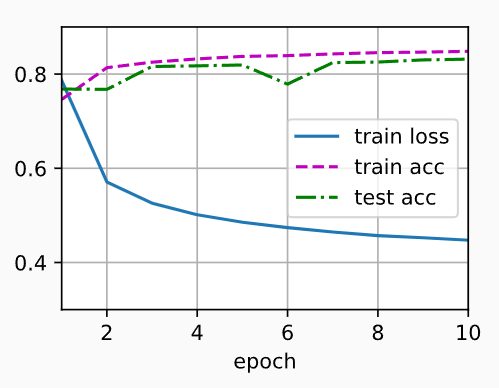

## Prediction

Now that training is complete, our model is ready to classify some images. Given a series of images, we will compare their actual labels (first line of text output) and the predictions from the model (second line of text output).

In [ ]:
def predict_ch3(net, test_iter, n=6):  #save
    """Predict labels (defined in Chapter 3)."""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

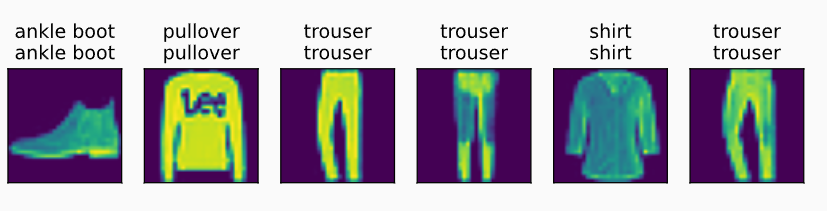

## Summary



*   With softmax regression, we can train models for multiclass classification.
*   The training loop of softmax regression is very similar to that in linear regression: retrieve and read data, define models and loss functions, then train models using optimization algorithms. As you will soon find out, most common deep learning models have similar training procedures.

